---

Load libraries

---

In [1]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import confusion_matrix
plt.style.use('dark_background')
%matplotlib inline

---

Set printing precision

---

In [2]:
np.set_printoptions(precision = 2)

---

Mount Google drive

---

In [3]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/EvenSemester2024/DL/Codes'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


---

Load MNIST Data

---

In [4]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[1]
num_samples = X_train.shape[0]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

# Normalize the samples (images) using the training data
xmax = np.amax(X_train) # 255
xmin = np.amin(X_train) # 0
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin) / (xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

We consider a softmax classfier, which is a 1-layer neural network or a 0-hidden layer neural network, for a batch comprising $b$ samples represented as the $b\times 784$-matrix $$\mathbf{X} = \begin{bmatrix}{\mathbf{x}^{(0)}}^\mathrm{T}\\{\mathbf{x}^{(1)}}^\mathrm{T}\\\vdots\\{\mathbf{x}^{(b-1)}}^\mathrm{T}\end{bmatrix}$$ with one-hot encoded true labels represented as the $b\times 10$-matrix (10 possible categories) $$\mathbf{Y}=\begin{bmatrix}{\mathbf{y}^{(0)}}^\mathrm{T}\\{\mathbf{y}^{(1)}}^\mathrm{T}\\\vdots\\{\mathbf{y}^{(b-1)}}^\mathrm{T}\end{bmatrix}.$$

The forward propagation for a generic sample in the batch seen as a $1\times784$-object $\mathbf{x}^\mathrm{T}$ with the bias feature $1$ added is presented below:

$$\small\begin{align*}
\boxed{\underbrace{\mathbf{x}_B^\mathrm{T}}_{1\times785}=\begin{bmatrix}\mathbf{x}^\mathrm{T}&1\end{bmatrix}}&\rightarrow\boxed{\underbrace{{\mathbf{z}}^\mathrm{T}}_{1\times 10} = \underbrace{\mathbf{x}_B^\mathrm{T}}_{1\times785}\underbrace{{\mathbf{W}}}_{785\times10}}\rightarrow\boxed{\underbrace{{\mathbf{a}}^\mathrm{T}}_{1\times10}=\text{softmax}\left(\underbrace{{\mathbf{z}}^\mathrm{T}}_{1\times10}\right)}\rightarrow\boxed{L = \sum\limits_{k=0}^9-y_k\log\left(\hat{y}_k\right)}.
\end{align*}$$

The forward propagation for the same generic sample seen as a $784$-vector $\mathbf{x}$ with the bias feature $1$ added is presented below (note that the weight matrix has the same name $\mathbf{W}$ as above for simplicity even though it should show up as $\mathbf{W}^\mathrm{T}$):

$$\small\begin{align*}
\boxed{\underbrace{\mathbf{x}_B}_{785}=\begin{bmatrix}\mathbf{x}\\1\end{bmatrix}}&\rightarrow\boxed{\underbrace{\mathbf{z}}_{10} = \underbrace{\mathbf{W}}_{10\times785}\underbrace{\mathbf{x}_B}_{785}}\rightarrow\boxed{\underbrace{\mathbf{a}}_{10}=\text{softmax}\left(\underbrace{\mathbf{z}}_{10}\right)}\rightarrow\boxed{L = \sum\limits_{k=0}^9-y_k\log\left(\hat{y}_k\right)}.\end{align*}$$

We will derive the update rule for the weights matrix $\mathbf{W}$ using the setup above.


The average crossentropy (CCE) loss for the batch is:$$\begin{align*}L &=\frac{1}{b}\left[L_0+L_1+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[\sum\limits_{k=0}^9{\color{yellow}-}y_k^{(0)}\log\left(\hat{y}^{(0)}_k\right)+\sum\limits_{k=0}^9{\color{yellow}-}y_k^{(1)}\log\left(\hat{y}^{(1)}_k\right)+\cdots+\sum\limits_{k=0}^9{\color{yellow}-}y_k^{(b-1)}\log\left(\hat{y}^{(b-1)}_k\right)\right]\\&=\frac{1}{b}\left[{\color{yellow}-}{\mathbf{y}^{(0)}}^\mathrm{T}\log\left({\hat{\mathbf{y}}^{(0)}}\right)+{\color{yellow}-}{\mathbf{y}^{(1)}}^\mathrm{T}\log\left({\hat{\mathbf{y}}^{(1)}}\right)+\cdots+{\color{yellow}-}{\mathbf{y}^{(b-1)}}^\mathrm{T}\log\left({\hat{\mathbf{y}}^{(b-1)}}\right)\right].\end{align*}$$

The computational graph for the samples, each at a time treated as a $785$-vector, in the batch are presented below where the weights matrix has shape $10\times 785.$

$\hspace{1.5in}\begin{align*}L_0\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(0)} &= \mathbf{a}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$$\hspace{0.25in}\begin{align*}L_1\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(1)} &= \mathbf{a}^{(1)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(1)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$$\qquad\cdots\qquad$$\begin{align*} L_{b-1}\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(b-1)} &= \mathbf{a}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$

The gradient of the average batch loss w.r.t. the weights is:
$$\small\begin{align*}\Rightarrow \nabla_\mathbf{W}(L) &=\frac{1}{b}\left[\nabla_\mathbf{W}(L_0)+\nabla_\mathbf{W}(L_1)+\cdots+\nabla_\mathbf{W}(L_{b-1})\right]\end{align*}$$
which by chain rule can be written as:

$$\small\begin{align*}\Rightarrow \nabla_\mathbf{W}(L) &= \frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left(\hat{\mathbf{y}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\nabla_\mathbf{W}(L_0)}+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(1)}\right) \times\nabla_{\mathbf{z}^{(1)}}\left(\hat{\mathbf{y}}^{(1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(1)}}(L_1)\right]}_{\nabla_\mathbf{W}(L_1)}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\nabla_\mathbf{W}(L_{b-1})}\right)\\&=\frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\nabla_\mathbf{W}(L_0)}+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(1)}\right) \times\nabla_{\mathbf{z}^{(1)}}\left({\mathbf{a}}^{(1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(1)}}(L_1)\right]}_{\nabla_\mathbf{W}(L_1)}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\nabla_\mathbf{W}(L_{b-1})}\right)\\&=\frac{1}{b}\sum_{i=0}^{b-1}\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(i)}\right) \times\nabla_{\mathbf{z}^{(i)}}\left({\mathbf{a}}^{(i)}\right)\times\nabla_{\hat{\mathbf{y}}^{(i)}}(L_i)\right]\\&=\frac{1}{b}\sum_{i=0}^{b-1}\left[\nabla_\mathbf{W}\left(\mathbf{W}{\mathbf{x}^{(i)}_B}\right) \times\nabla_{\mathbf{z}^{(i)}}\left(\text{softmax}\left({\mathbf{z}}^{(i)}\right)\right)\times\nabla_{\hat{\mathbf{y}}^{(i)}}\left(-{\mathbf{y}^{(i)}}^\mathrm{T}\log\left(\hat{\mathbf{y}}^{(i)}\right)\right)\right],\end{align*}$$
which can be written as

$$\begin{align*}\nabla_{\mathbf{W}}(L) &= \dfrac{1}{b}\displaystyle\sum_{i=0}^{b-1}\underbrace{\begin{bmatrix}\boxed{{\mathbf{x}^{(i)}_B}\ \pmb{0}\ \pmb{0}\ \ldots\ \pmb{0}}&&&&\\\\&\boxed{\pmb{0}\ {\mathbf{x}^{(i)}_B}\ \pmb{0}\ \ldots\ \pmb{0}}&&&\\&\hspace{1cm}\ddots&&&\\&&\hspace{-0.5cm}\ddots&&\\&&&\boxed{\pmb{0}\ \pmb{0}\ \ldots\ \pmb{0}\ {\mathbf{x}^{(i)}_B}}&\end{bmatrix}}_{\color{cyan}{\nabla_\mathbf{W}\left(\mathbf{z}^{(i)}\right)=\nabla_\mathbf{W}\left(\mathbf{W}{\mathbf{x}^{(i)}_B}\right):\ 10\times785\times10}}\underbrace{\begin{bmatrix}a^{(i)}_0 (1 - a^{(i)}_0) & -a^{(i)}_0 a^{(i)}_1 & \cdots & -a^{(i)}_0 a^{(i)}_9\\-a^{(i)}_1 a^{(i)}_0 & a^{(i)}_1 (1 - a^{(i)}_1) & \cdots & -a^{(i)}_1 a^{(i)}_9\\\vdots & \vdots & \ddots & \vdots\\-a^{(i)}_9 a^{(i)}_0 & -a^{(i)}_9 a^{(i)}_1 & \cdots & a^{(i)}_9 (1 - a^{(i)}_9)\end{bmatrix}}_{\color{cyan}{\nabla_{\mathbf{z}^{(i)}}\left({\mathbf{a}}^{(i)}\right) = \nabla_{\mathbf{z}^{(i)}}\left(\text{softmax}\left({\mathbf{z}}^{(i)}\right)\right):\ 10\times10}}\underbrace{\begin{bmatrix}-\frac{y^{(i)}_0}{\hat{y}^{(i)}_0}\\-\frac{y^{(i)}_1}{\hat{y}^{(i)}_1}\\\vdots\\-\frac{y^{(i)}_9}{\hat{y}^{(i)}_9}\end{bmatrix}}_{\color{cyan}{\nabla_{\hat{\mathbf{y}}^{(i)}}(L_i)=\nabla_{\hat{\mathbf{y}}^{(i)}}\left(-{\mathbf{y}^{(i)}}^\mathrm{T}\log\left(\hat{\mathbf{y}}^{(i)}\right)\right):\ 10\times1}}\end{align*}$$

The forward and backward propagation showing the gradient flow for a generic sample is shown below:

![](https://1drv.ms/i/c/37720f927b6ddc34/IQS3b-biQ4W9QpCtJzaZnyCoAQ8_r9i707rpOE1O9I0yntM?width=686&height=93)

$$\begin{align*}\nabla_{\mathbf{W}}(L) &=\dfrac{1}{b}\displaystyle\sum_{i=0}^{b-1}\underbrace{\begin{bmatrix}a^{(i)}_0 (1 - a^{(i)}_0) & -a^{(i)}_0 a^{(i)}_1 & \cdots & -a^{(i)}_0 a^{(i)}_9\\-a^{(i)}_1 a^{(i)}_0 & a^{(i)}_1 (1 - a^{(i)}_1) & \cdots & -a^{(i)}_1 a^{(i)}_9\\\vdots & \vdots & \ddots & \vdots\\-a^{(i)}_9 a^{(i)}_0 & -a^{(i)}_9 a^{(i)}_1 & \cdots & a^{(i)}_9 (1 - a^{(i)}_9)\end{bmatrix}}_{\color{cyan}{=\left(\mathbf{I}-{\mathbf{a}^{(i)}}^\mathrm{T}\right)\otimes\mathbf{a}^{(i)}}}\underbrace{\begin{bmatrix}-\frac{y^{(i)}_0}{\hat{y}^{(i)}_0} \\
-\frac{y^{(i)}_1}{\hat{y}^{(i)}_1}\\\vdots\\-\frac{y^{(i)}_9}{\hat{y}^{(i)}_9}\end{bmatrix}}_{\color{cyan}{=-\frac{\mathbf{y}^{(i)}}{\hat{\mathbf{y}}^{(i)}}}}{\mathbf{x}^{(i)}_B}^\mathrm{T}.\end{align*}$$

We can write the gradient in the following way for efficient coding purposes: $$\nabla_\mathbf{W}(L) = \frac{1}{b}\sum_{i=0}^{b-1}\left[\left(\mathbf{I}-{\mathbf{a}^{(i)}}^\mathrm{T}\right)\otimes\mathbf{a}^{(i)}\right]\left[-\frac{\mathbf{y}^{(i)}}{\hat{\mathbf{y}}^{(i)}}\right]{\mathbf{x}^{(i)}_B}^\mathrm{T}.$$


It can be seen that the gradient object has shape $(10\times 10)\times(10\times1)\times(1\times785)=10\times785,$ which is the same shape as the weights matrix $\mathbf{W}.$ However, our derivation here assumed that the samples are seen as column vectors of the data matrix. The original data matrix has the samples arranged as rows which corresponded to the weights matrix of shape $785\times10.$ In order to get the gradient w.r.t. that weights matrix, we have to transpose this expression resulting in the update $$\nabla_\mathbf{W}(L) = \frac{1}{b}\sum_{i=0}^{b-1}\underbrace{\mathbf{x}^{(i)}_B}_{\color{yellow}{785\times1}}\underbrace{\underbrace{\left[-\frac{{\mathbf{y}^{(i)}}^\mathrm{T}}{{\hat{\mathbf{y}}^{(i)}}^\mathrm{T}}\right]}_{\color{magenta}{\text{output side gradient of softmax layer: }1\times10}}\underbrace{\left[\left(\mathbf{I}-{\mathbf{a}^{(i)}}\right)\otimes{\mathbf{a}^{(i)}}^\mathrm{T}\right]}_{\color{magenta}{\text{local gradient of softmax layer: }10\times10}}}_{\color{yellow}{\text{output side gradient of dense layer: }1\times10}}.$$



Note that when regularization is applied to the weights using a regularization strength $\lambda,$ then the regularization loss gets added to the data loss to give the total loss for the batch as follows: $$\begin{align*}L &= L_\text{data}+L_\text{reg}\\&=\frac{1}{b}\left[L_0+L_1+\cdots+L_{b-1}\right]+\lambda\left[{\mathbf{w}^{(0)}}^\mathrm{T}\mathbf{w}^{(0)}+{\mathbf{w}^{(1)}}^\mathrm{T}\mathbf{w}^{(1)}+\cdots+{\mathbf{w}^{(783)}}^\mathrm{T}\mathbf{w}^{(783)}\right].\end{align*}$$
Note that the last row of the weights matrix $\mathbf{W},$ which comprises the bias values, are not included in the regularization loss.

The gradient w.r.t. the weights matrix $\mathbf{W}$ now also includes the gradient w.r.t. the regularization loss as follows: $$\begin{align*}\nabla_\mathbf{W}(L)&=\nabla_\mathbf{W}\left(\frac{1}{b}\left[L_0+L_1+\cdots+L_{b-1}\right]\right)+\lambda\nabla_\mathbf{W}\left(L_\text{reg}\right)\\&=\underbrace{\frac{1}{b}\sum_{i=0}^{b-1}{\mathbf{x}^{(i)}_B}\left[-\frac{{\mathbf{y}^{(i)}}^\mathrm{T}}{{\hat{\mathbf{y}}^{(i)}}^\mathrm{T}}\right]\left[\left(\mathbf{I}-{\mathbf{a}^{(i)}}\right)\otimes{\mathbf{a}^{(i)}}^\mathrm{T}\right]}_{\text{data gradient}}+\lambda\underbrace{\begin{bmatrix}2{\mathbf{w}^{(0)}}^\mathrm{T}\\2{\mathbf{w}^{(1)}}^\mathrm{T}\\\vdots\\2{\mathbf{w}^{(783)}}^\mathrm{T}\\\pmb{0}\end{bmatrix}}_{\text{regularization gradient}}.\end{align*}$$


---

---

A generic layer class with forward and backward methods

----

In [5]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

CCE loss and its gradient for the batch samples

---

In [6]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 1), axis = 0))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

---

Softmax activation layer class


---

In [7]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.input = input
    self.output = tf.nn.softmax(self.input, axis = 1).numpy()

  def backward(self, output_gradient, learning_rate = None):
    I = np.identity(self.output.shape[1])
    local_gradient = (I - self.output[:, :, np.newaxis]) * self.output[:, np.newaxis, :]
    return(np.einsum('ij,ijk->ik', output_gradient, local_gradient))

---

Dense layer class

---

In [8]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength = 0.0):
        self.weights = 0.01*np.random.randn(input_size+1, output_size) # bias trick
        self.weights[-1, :] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.hstack([input, np.ones((input.shape[0], 1))]) # bias trick
        # Forward propagation
        self.output= np.dot(self.input, self.weights)
        # Calculate regularization loss
        self.reg_loss = self.reg_strength * np.sum(self.weights[:-1, :] * self.weights[:-1, :])

    def backward(self, output_gradient, learning_rate):
        # Calculate gradient w.r.t. dense layer weights from all inputs
        weights_gradient = (1/output_gradient.shape[0]) * (np.einsum('ij,ik->jk', self.input, output_gradient))
        # Add the regularization gradient here
        weights_gradient += 2 * self.reg_strength * np.vstack([self.weights[:-1, :], np.zeros((1, self.weights.shape[1]))])
        # Update weights for dense layer
        self.weights = self.weights + learning_rate * (-weights_gradient)

---

Function to generate sample indices for batch processing according to batch size

---

In [9]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Example generation of batch indices

---

In [10]:
## Example generation of batch indices
batch_size = 16
batch_indices = generate_batch_indices(64, batch_size)
print(batch_indices)

[array([13, 45,  8, 14,  6, 55, 50,  9, 32, 59,  0, 16, 34, 36, 49, 26]), array([41, 19, 63, 17, 20, 40,  1, 35, 42, 23, 24, 43, 46, 61, 12, 31]), array([54, 57, 28, 60, 18, 10, 33, 44, 53,  7, 15, 47, 56, 58,  4, 38]), array([62, 37, 51, 27, 48, 52,  3, 22,  2,  5, 11, 29, 25, 39, 21, 30])]


---

Train the 1-layer neural (softmax) neural network using batch training with batch size = 100

---

In [31]:
## Train the 1-layer neural network using batch training with batch size = 100
learning_rate = 1e-02
batch_size = 100
nepochs = 50
reg_strength = 0.1
# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)
# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)

# Neural network architecture ()
dlayer1 = Dense(num_features, num_labels, reg_strength) # define dense layer 1
softmax = Softmax() # define softmax activation layer

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.
epoch = 0
# Run over each epoch
while epoch < nepochs:
  # Generate the batches
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  # Run over each batch of samples
  for b in range(len(batch_indices)):
    # Forward prop starts here
    dlayer1.forward(X_train[batch_indices[b], :]) # forward prop dense layer 1
    softmax.forward(dlayer1.output) # forward prop softmax activation layer
    loss += cce(Y_train[batch_indices[b], :], softmax.output)
    # Add the regularization losses
    loss += dlayer1.reg_loss
    # Forward prop ends and backward prop starts here
    grad = cce_gradient(Y_train[batch_indices[b], :], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)

  # Forward propagation for test data
  dlayer1.forward(X_test)
  softmax.forward(dlayer1.output)

  # Calculate test data loss plus regularization loss
  loss_test_epoch[epoch] =  cce(Y_test, softmax.output) + dlayer1.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 1.530762, test loss = 1.334671
Epoch 2: train loss = 1.349964, test loss = 1.321524
Epoch 3: train loss = 1.344343, test loss = 1.319655
Epoch 4: train loss = 1.342193, test loss = 1.317368
Epoch 5: train loss = 1.340616, test loss = 1.315725
Epoch 6: train loss = 1.339018, test loss = 1.314134
Epoch 7: train loss = 1.337686, test loss = 1.313425
Epoch 8: train loss = 1.336498, test loss = 1.312158
Epoch 9: train loss = 1.335619, test loss = 1.311157
Epoch 10: train loss = 1.334676, test loss = 1.310651
Epoch 11: train loss = 1.333817, test loss = 1.309821
Epoch 12: train loss = 1.333158, test loss = 1.308919
Epoch 13: train loss = 1.332288, test loss = 1.309182
Epoch 14: train loss = 1.331871, test loss = 1.308543
Epoch 15: train loss = 1.331382, test loss = 1.307835
Epoch 16: train loss = 1.331006, test loss = 1.306936
Epoch 17: train loss = 1.330582, test loss = 1.307016
Epoch 18: train loss = 1.330141, test loss = 1.306531
Epoch 19: train loss = 1.329884, test

---

Plot training and test loss vs. epoch

---

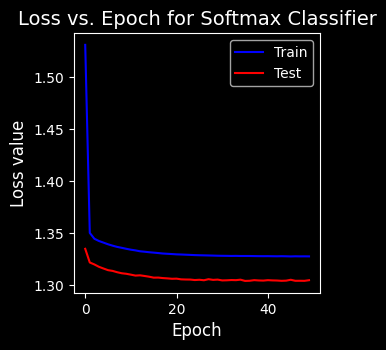

In [32]:
## Plot train and test loss as a function of epoch:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for Softmax Classifier', fontsize = 14);

---

Assess model performance on test data

---

In [35]:
## Assess model performance on test data
dlayer1.forward(X_test)
#alayer1.forward(dlayer1.output)
#dlayer2.forward(alayer1.output)
softmax.forward(dlayer1.output)
ypred = np.argmax(softmax.output, axis = 1)
ytrue = np.argmax(Y_test, axis = 1)
print('Accuracy on test data = %3.2f'%(np.mean(ytrue == ypred)*100))
# Print confusion matrix
print(confusion_matrix(ytrue, ypred))

Accuracy on test data = 85.12
[[ 939    0    2    5    1    9   19    1    4    0]
 [   0 1105    6    3    0    1    4    0   16    0]
 [  19   63  792   30   27    0   27   27   45    2]
 [   5   18   21  873    1   22    9   22   30    9]
 [   1   19    3    0  880    1   22    3    7   46]
 [  25   53    0  108   31  589   35   22   17   12]
 [  20   15   11    1   13   17  879    1    1    0]
 [   3   53   20    2   15    0    2  902    5   26]
 [  12   48   12   55   14   17   19   15  761   21]
 [  20   19   10   12   82    7    4   52   11  792]]


Image classified as 3


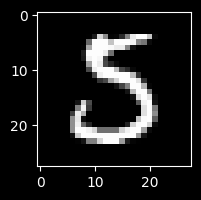

In [38]:
## Plot a random test sample with its predicted label printed above the plot
test_index = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1, 1, figsize = (2, 2))
print(f'Image classified as {ypred[test_index]}')
ax.imshow(tf.reshape(X_test[test_index], [28, 28]).numpy(), cmap = 'gray');